In [2]:
from __future__ import division
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from math import inf, sqrt

In [3]:
from skimage import data, color
from skimage.transform import rescale, resize

In [4]:
im = Image.open("image/04_sample")

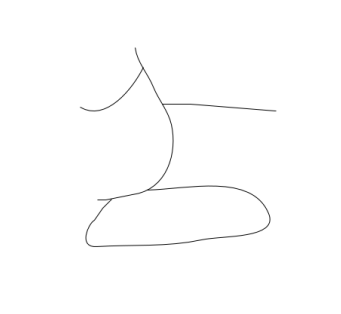

In [5]:
im

In [6]:
im_array = np.asarray(im.convert('L'))

In [7]:
im_array.shape

(314, 341)

In [8]:
im_array = resize(im_array, (100, 100))*256

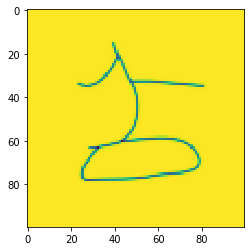

In [9]:
plt.imshow(im_array)
plt.show()

## Fast marching with Djikstra

In [10]:
W = im_array

In [11]:
n = im_array.shape[0]

In [33]:
x_start = np.where(np.sum(im_array<200, axis=0) != 0)[0][0]
y_start = np.where(np.sum(im_array<200, axis=1) != 0)[0][0]
x_start = 38
y_start = 18
start_point = (x_start, y_start)

In [34]:
start_point = (38, 18)

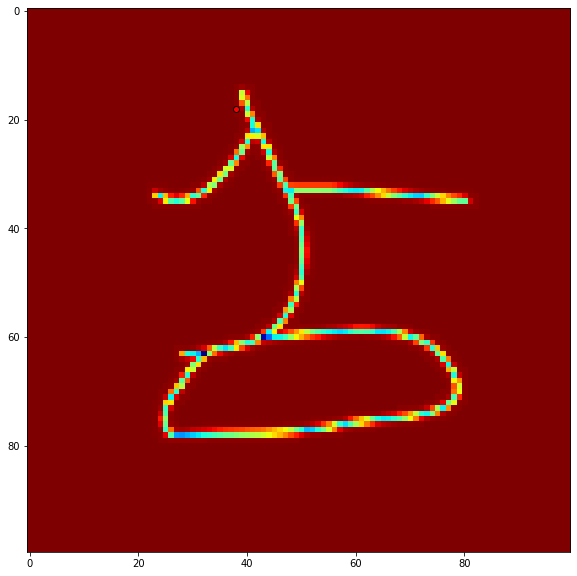

In [35]:
plt.figure(figsize=(10, 10))
plt.scatter(start_point[0], start_point[1], color='r', edgecolor='k')
plt.imshow(im_array, cmap='jet')
plt.show()

In [37]:
neigh = np.array([[1, -1, 0, 0], [0, 0,  1, -1]])

In [38]:
### Operation of boundary enforcement
boundary = lambda x: np.mod(x,n)
# From 1d index to 2d coordinates
ind2sub1 = lambda k: [int( (k-np.fmod(k,n))/n ), np.fmod(k,n)]
# From 2d coordinates to 1d index
sub2ind1 = lambda u: int( u[0]*n + u[1] )
# Get Neigh 2d coordinates in constrained space
Neigh = lambda k,i: sub2ind1(boundary(ind2sub1(k) + neigh[:,i]))

In [39]:
def is_border(pixel_coord):
    """
        Input:
            pixel_coord: <np.array of length 2>
    """
    global n
    return bool(np.sum(pixel_coord==0) + np.sum(pixel_coord==n))

In [40]:
def Neigh(k, i):
    neigh_coord = boundary(ind2sub1(k) + neigh[:,i])
    if is_border(neigh_coord):
        return None
    else:
        return sub2ind1(neigh_coord)

In [41]:
x0 = [y_start, x_start]
# Initial stack
I = [sub2ind1(x0)]

# Inital distance to x0 (Update through min so inf)
D = np.ones((n,n)) + inf
u = ind2sub1(I)
D[u[0],u[1]] = 0

# To visit or not
S = np.zeros((n,n))
S[u[0],u[1]] = 1

In [42]:
extract   = lambda x,I: x[I]

In [43]:
def extract1d(x, I):
    if I is None:
        return inf
    else: 
        return extract(x.flatten(),I)

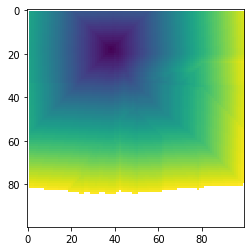

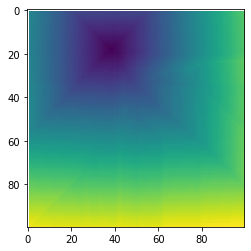

Done.


In [44]:
count = 0

while I:
    
    count += 1
    
    j = np.argsort( extract1d(D,I)  )
    if np.ndim(j)==0:
        j = [j]   # make sure that j is a list a not a singleton
        
    j = j[0]
    i = I[j]         
    a = I.pop(j)
    
    u = ind2sub1(i);
    S[u[0],u[1]] = -1
    
    
    J = [] 
    for k in np.arange(0,4):
        v_ = Neigh(i,k)
        if v_ is None:
             continue
        j = v_
        if extract1d(S,j)!=-1:
            # add to the list of point to update
            J.append(j)
            if extract1d(S,j)==0:
                # add to the front
                u = ind2sub1(j)
                S[u[0],u[1]] = 1
                I.append(j)

    DNeigh = lambda D,k: extract1d(D,Neigh(j,k))
    
    # Update distance of the points
    for j in J:
        
        # Update by L1 min
        dx = min(DNeigh(D,0), DNeigh(D,1))
        dy = min(DNeigh(D,2), DNeigh(D,3))
        u = ind2sub1(j)
        w = extract1d(W,j);

        Delta = 2*w - (dx-dy)**2
        if (Delta>=0):
            D[u[0],u[1]] = (dx + dy + sqrt(Delta))/ 2
        else:
            D[u[0],u[1]] = min(dx + w, dy + w)    
            
    if count % 8000 == 0:
        plt.imshow(D)
        plt.show()

plt.imshow(D)
plt.show()

print('Done.')

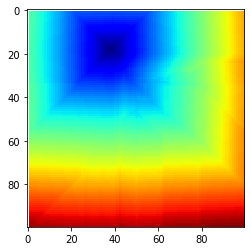

In [45]:
plt.imshow(D, cmap='jet')
plt.show()

## Once we have the distance map, let's do the backpropagation from the specified endpoint

In [46]:
x_start = np.where(np.sum(im_array<200, axis=0) != 0)[0][0]
y_start = np.where(np.sum(im_array<200, axis=1) != 0)[0][0]
start_point = (x_start, y_start)

In [47]:
x_end = np.where(np.sum(im_array<200, axis=0) != 0)[0][-1]
y_end = np.where(np.sum(im_array<200, axis=1) != 0)[0][-1]
end_point = (x_end, y_end)

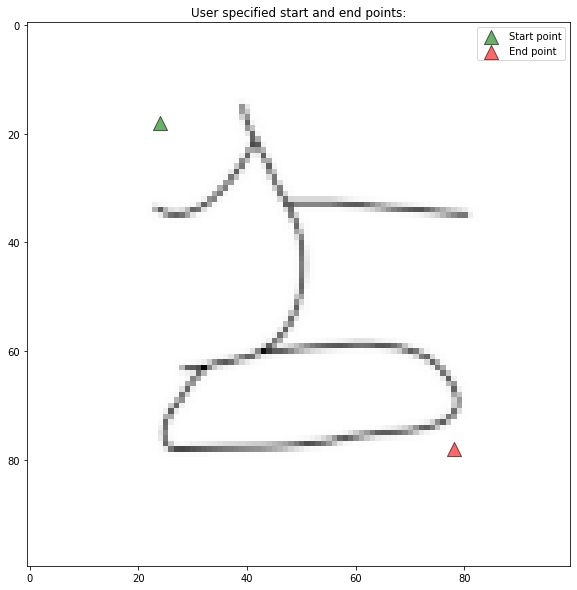

In [48]:
plt.figure(figsize=(10, 10))
plt.title('User specified start and end points:')
plt.scatter(start_point[0], start_point[1], color='g', edgecolor='k', s=200, marker='^', alpha=0.6, label='Start point')
plt.scatter(end_point[0], end_point[1], color='r', edgecolor='k', s=200, marker='^', alpha=0.6, label='End point')
plt.imshow(im_array, cmap='gray')
plt.legend()
plt.show()

## Back Propagation

In [49]:
start_point, end_point

((24, 18), (78, 78))

In [50]:
min_path = [list(end_point)]

max_iter = 300
count = 0

while np.prod(min_path[-1] == start_point)!=1 and count < max_iter:
    
    point = min_path[-1]
    neighbors_mat = np.array(list(point)).reshape(2, 1) + neigh
    
    min_distance = np.inf

    for k in range(4):
        coord = neighbors_mat[:, k]
        distance = D[coord[1], coord[0]]
        if distance < min_distance:
            min_distance = distance
            next_point = coord
    
    min_path.append(list(next_point))
    
    count += 1

min_path = np.array(min_path)

In [51]:
len(min_path)

301

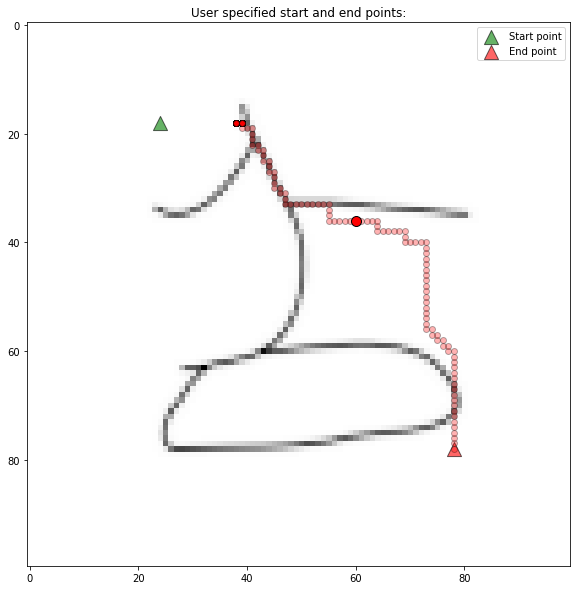

In [52]:
N = 60

plt.figure(figsize=(10, 10))
plt.title('User specified start and end points:')
plt.scatter(start_point[0], start_point[1], color='g', edgecolor='k', s=200, marker='^', alpha=0.6, label='Start point')
plt.scatter(end_point[0], end_point[1], color='r', edgecolor='k', s=200, marker='^', alpha=0.6, label='End point')
plt.scatter(min_path[:, 0], min_path[:, 1], color='r', edgecolor='k', alpha=0.3)
plt.scatter(min_path[N][0], min_path[N][1], color='r', edgecolor='k', alpha=1, s=100)
plt.imshow(im_array, cmap='gray')
plt.legend()
plt.show()